In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
import os
import torch
from PIL import Image
import shutil
import random

# Detecção de Carros com Análise de Movimento

Desenvolver um modelo de detecção de carros utilizando um vídeo gravado em um cruzamento. O objetivo é explorar informações espaciais e temporais para aprimorar a detecção de veículos.

---

- Murilo Lima Lirani de Carvalho (11234673)  
- Enzo Castelo Branco Biondi (14568142)  
- Vinicio Yusuke Hayashibara (13642797)  
- Julia Pravato (14615054)  
- Marcos Paulo Rocha Baltazar (13782373)  
- Laura Nannetti Moreira (12557504)

---

## Etapas do Processo

### 1. Leitura do Vídeo e Geração de Rótulos com Modelo Pré-Treinado

- Um vídeo de 80 minutos foi capturado em um cruzamento com tráfego de veículos.  
- A leitura do vídeo é feita para extração de frames a intervalos definidos.  
- Os frames extraídos ainda não possuem rótulos.  
- Utiliza-se um modelo pré-treinado YOLOv5 para detectar veículos nesses frames individualmente.  
- As bounding boxes geradas pelo modelo servem como rótulos automáticos.  
- Os frames selecionados e seus respectivos labels são salvos como dataset para as próximas etapas.

---

### 2. Construção de um Novo Dataset

- Cada imagem do dataset passa por um processo de realce das regiões com movimento:  
  - Em vez de adicionar um quarto canal, os três canais da imagem original são modificados diretamente.  
  - Utiliza-se uma máscara binária obtida pela diferença entre o frame atual e o background.
  - As regiões com movimento são realçadas multiplicando os valores dos pixels por um fator de realce:  
    **imagem_realçada = normalizar [ imagem_original * (1 + alpha * máscara_binária) ]**  
  - Esse procedimento intensifica os valores de pixels nas regiões com movimento recente, chamando a atenção do modelo para essas áreas.
- Não foram utilizadas técnicas de data augmentation, exceto as feitas automaticamente pelo finetuning do modelo yolo.

---

### 3. Construção da Máscara de Movimento

1. Seleção de 5 minutos de vídeo para construir o background. (Na prática, isso poderia ser atualizado periodicamente).  
2. Para cada pixel, calcula-se a moda dos valores de todos os frames nesses 5 minutos.  
   - A moda é eficaz nesse contexto, pois a câmera é estática e o valor mais comum representa o fundo (ex: asfalto).  
   - Objetos móveis, como carros, ocupam um pixel por curtos períodos, não afetando a moda.  
3. Subtrai-se o background calculado de cada frame do vídeo.  
4. Calcula-se a diferença absoluta e aplica-se um limiar para gerar uma máscara binária de movimento.  
5. Essa máscara binária é então utilizada para realçar visualmente as regiões com movimento nas imagens RGB.

---

### 4. Treinamento de Novo Modelo

- Um novo modelo será treinado a partir do dataset criado, utilizando:  
  - As imagens com regiões realçadas.  
  - As bounding boxes criadas pelo YOLOv5 como rótulos.  
- A métrica utilizada para avaliação será baseada nas intersecções entre bounding boxes.

---
## Relatório

Esse notebook contém os procedimentos utilizados para gerar os resultados encontrados. No entanto, como os processos foram divididos entre vários autores/computadores, estão apresentados apenas os modelos de criação, junto a imagens fixadas dos resultados como exemplos em 'markdown'.


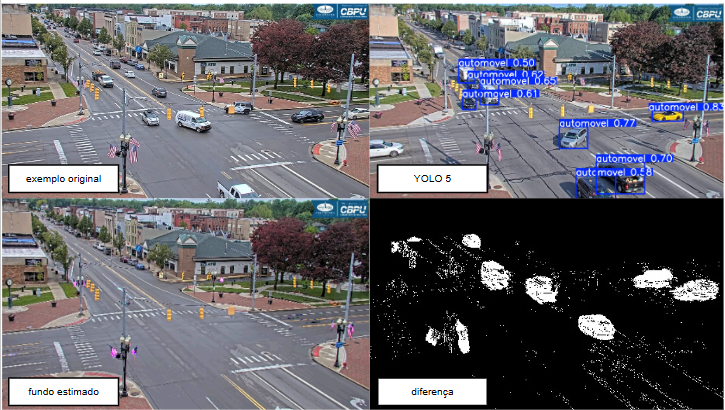

## Rotular com YOLO

### Pegando frames do vídeo

In [ ]:
# Caminho do vídeo e pasta de saída
video_path = 'sample5.mp4'
output_folder = 'imagens_p_treino'

# Criar a pasta de saída caso não exista
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Abrir o vídeo
cap = cv2.VideoCapture(video_path)

# Taxa de quadros do vídeo
fps = cap.get(cv2.CAP_PROP_FPS)
frame_interval = int(fps * 3)  # Capturar um frame a cada 3 segundos

frame_number = 0
frame_index = 0

while frame_number < 2:
    # Captura um frame do vídeo
    ret, frame = cap.read()

    # Se não houver mais frames, o vídeo terminou
    if not ret:
        break

    if frame_index % frame_interval == 0:
        # Salva o frame como imagem
        # frame_filename = os.path.join(output_folder, f'frame_{frame_number:04d}.jpg')
        # cv2.imwrite(frame_filename, frame)
        frame_number += 1

    # Atualiza o contador de frames
    frame_index += 1

# Libera o vídeo após a extração
cap.release()
print(f'Frames extraídos: {frame_number}')

Frames extraídos: 2


### Gerando os rótulos

In [ ]:
# Carregar o modelo YOLOv5 pré-treinado (usando a versão mais leve, yolov5s)
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # YOLOv5s é a versão mais rápida

# Caminho onde as imagens estão armazenadas
frames_folder = 'imagens_p_treino'  # Caminho para a pasta com os frames extraídos
counter = 0
# Iterar pelos frames extraídos e realizar a detecção
for frame_filename in os.listdir(frames_folder):
    if (frame_filename.endswith('.jpg')) and counter < 2 :  # Verificar se é uma imagem JPEG
        frame_path = os.path.join(frames_folder, frame_filename)
        counter = counter + 1

        # Carregar a imagem
        img = Image.open(frame_path)

        # Realizar a detecção no frame usando o modelo YOLOv5
        results = model(img)

        # Obter as caixas delimitadoras, os IDs das classes e a confiança
        detections = results.xywh[0]  # Detecções em coordenadas xywh (x_center, y_center, width, height)

        # Apenas para visualização (não salva os rótulos)
        for detection in detections:
            class_id = int(detection[5])  # ID da classe (0 para "carro")
            confidence = float(detection[4])  # Confiança da detecção
            x_center = float(detection[0])  # Centro da caixa
            y_center = float(detection[1])
            width = float(detection[2])
            height = float(detection[3])

        # Mostrar a imagem com as caixas delimitadoras (não salva, só exibe)
        results.show()

print("Processamento de detecção completo!")


### Arrumando os labels do modelo

In [ ]:
print(model.names)
#Queremos apenas os automóveis, ou seja, labels 2, 3 e 7

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [ ]:
def unifica_labels():
  original_labels_folder = 'imagens_p_treino/labels' # Onde os labels originais estão (gerados pelo YOLOv5)
  unified_labels_folder = 'MeuProjetoCarros/unified_labels' # Nova pasta para os labels unificados

  os.makedirs(unified_labels_folder, exist_ok=True)

  # Definir os IDs das classes que queremos manter, conforme o modelo YOLOv5 no COCO
  # car=2, motorcycle=3, truck=7
  allowed_and_unify_classes_ids = {2, 3, 7}

  # O novo ID para todas essas classes será 0
  unified_class_id = 0

  for filename in os.listdir(original_labels_folder):
      if not filename.endswith('.txt'):
          continue

      input_filepath = os.path.join(original_labels_folder, filename)
      output_filepath = os.path.join(unified_labels_folder, filename)

      lines_to_write = []
      with open(input_filepath, 'r') as infile:
          for line in infile:
              parts = line.strip().split()
              if not parts: # Pular linhas vazias
                  continue

              class_id = int(parts[0])

              if class_id in allowed_and_unify_classes_ids:
                  # Altera o ID da classe para o ID unificado (0)
                  parts[0] = str(unified_class_id)
                  lines_to_write.append(" ".join(parts))

      # Só escreve no arquivo de saída se houver pelo menos uma detecção de veículo
      if lines_to_write:
          with open(output_filepath, 'w') as outfile:
              for line in lines_to_write:
                  outfile.write(line + '\n')
      else:
          pass

# unifica_labels()

### Juntando com as imagens originais e separando em treino e validação

In [ ]:
def combine_and_split_data(split_ratio=0.8):

        # Caminho das pastas de dados originais
    original_images_folder = 'imagens_p_treino/'  # Imagens originais
    original_labels_unified_folder = 'imagens_p_treino/unified_labels/'  # Rótulos unificados

    # Caminho das pastas de dados aumentados
    augmented_images_folder = 'MeuProjetoCarros/augmented_images/'  # Imagens aumentadas
    augmented_labels_folder = 'MeuProjetoCarros/augmented_labels/'  # Rótulos aumentados

    # Onde o dataset final (treino/validação) será salvo
    final_dataset_images_base = 'MeuProjetoCarros/dataset_para_treino/images/'
    final_dataset_labels_base = 'MeuProjetoCarros/dataset_para_treino/labels/'

    # Criar pastas temporárias para o dataset combinado
    combined_images_temp = os.path.join(final_dataset_images_base, 'combined_images')
    combined_labels_temp = os.path.join(final_dataset_labels_base, 'combined_labels')
    os.makedirs(combined_images_temp, exist_ok=True)  # Cria a pasta se não existir
    os.makedirs(combined_labels_temp, exist_ok=True)

    # Copiar imagens e rótulos originais para a pasta temporária
    for filename in os.listdir(original_images_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # Verifica se é uma imagem
            base_name = os.path.splitext(filename)[0]
            img_src_path = os.path.join(original_images_folder, filename)
            label_src_path = os.path.join(original_labels_unified_folder, base_name + '.txt')

            # Copiar a imagem para a pasta temporária
            shutil.copy(img_src_path, combined_images_temp)

            # Copiar o rótulo (se existir) para a pasta temporária
            if os.path.exists(label_src_path):
                shutil.copy(label_src_path, os.path.join(combined_labels_temp, base_name + '.txt'))
            else:
                # Se não houver rótulo, cria um arquivo de rótulo vazio
                open(os.path.join(combined_labels_temp, base_name + '.txt'), 'w').close()

    # Copiar imagens e rótulos aumentados para a pasta temporária
    for filename in os.listdir(augmented_images_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # Verifica se é uma imagem
            base_name = os.path.splitext(filename)[0]
            img_src_path = os.path.join(augmented_images_folder, filename)
            label_src_path = os.path.join(augmented_labels_folder, base_name + '.txt')

            # Copiar a imagem aumentada para a pasta temporária
            shutil.copy(img_src_path, combined_images_temp)

            # Copiar o rótulo aumentada (se existir) para a pasta temporária
            if os.path.exists(label_src_path):
                shutil.copy(label_src_path, os.path.join(combined_labels_temp, base_name + '.txt'))
            else:
                # Se não houver rótulo, cria um arquivo de rótulo vazio
                open(os.path.join(combined_labels_temp, base_name + '.txt'), 'w').close()

    # Criar pastas para treino e validação
    train_img_folder = os.path.join(final_dataset_images_base, 'train')
    val_img_folder = os.path.join(final_dataset_images_base, 'val')
    train_label_folder = os.path.join(final_dataset_labels_base, 'train')
    val_label_folder = os.path.join(final_dataset_labels_base, 'val')

    os.makedirs(train_img_folder, exist_ok=True)
    os.makedirs(val_img_folder, exist_ok=True)
    os.makedirs(train_label_folder, exist_ok=True)
    os.makedirs(val_label_folder, exist_ok=True)

    # 1. Agrupar por nome base
    image_files = [f for f in os.listdir(combined_images_temp) if f.endswith('.jpg')]
    base_names = set(f.split('_aug')[0] if '_aug' in f else os.path.splitext(f)[0] for f in image_files)
    base_names = list(base_names)
    random.shuffle(base_names)

    # 2. Split pelos nomes-base
    num_train = int(len(base_names) * split_ratio)
    train_bases = set(base_names[:num_train])
    val_bases = set(base_names[num_train:])

    print(f"Total de frames base: {len(base_names)}")
    print(f"Bases para treino: {len(train_bases)}")
    print(f"Bases para validação: {len(val_bases)}")

    # 3. Associar imagens e labels de acordo com o base name
    for img_filename in image_files:
        base_name = img_filename.split('_aug')[0] if '_aug' in img_filename else os.path.splitext(img_filename)[0]
        label_filename = os.path.splitext(img_filename)[0] + '.txt'

        if base_name in train_bases:
            shutil.copy(os.path.join(combined_images_temp, img_filename), os.path.join(train_img_folder, img_filename))
            shutil.copy(os.path.join(combined_labels_temp, label_filename), os.path.join(train_label_folder, label_filename))
        elif base_name in val_bases:
            shutil.copy(os.path.join(combined_images_temp, img_filename), os.path.join(val_img_folder, img_filename))
            shutil.copy(os.path.join(combined_labels_temp, label_filename), os.path.join(val_label_folder, label_filename))

    print("Split finalizado com segurança sem vazamento de dados.")


# Combine e divida os dados
#combine_and_split_data()

In [ ]:
# Conteúdo do arquivo .yaml
yaml_content = """
# automovel_dataset.yaml
# Caminho base para o dataset
path: MeuProjetoCarros/dataset_para_treino/

# Caminhos relativos para os conjuntos de treino e validação
train: images/train
val: images/val

# Número de classes (automovel)
nc: 1

# Nomes das classes, na ordem dos IDs (começando do 0)
names: ['automovel']
"""

output_yaml_path = 'MeuProjetoCarros/automovel_dataset.yaml'

# Salvar o conteúdo no arquivo
#with open(output_yaml_path, 'w') as f:
    #f.write(yaml_content)

## Mapa de movimento

### Cálculo background

In [ ]:
video_path = 'sample5.mp4'
background_path = 'background.png'

In [ ]:
def gerar_background_por_moda(
    video_path,
    output_path,
    frame_interval_seconds=3,
    quantization=8,
    max_minutes=5,
    resize_shape=(640, 360)):

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps * frame_interval_seconds)
    max_frames = int(fps * 60 * max_minutes)

    # Pega dimensões originais do vídeo
    ret, first_frame = cap.read()
    if not ret:
        cap.release()
        return
    original_height, original_width = first_frame.shape[:2]
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    frames = []
    frame_count = 0

    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frame_resized = cv2.resize(frame, resize_shape, interpolation=cv2.INTER_NEAREST)
            quant_frame = (frame_resized // quantization).astype(np.uint8)
            frames.append(quant_frame)
        frame_count += 1

    cap.release()

    frames = np.stack(frames, axis=0)
    N, H, W, C = frames.shape
    background_q = np.zeros((H, W, C), dtype=np.uint8)

    for c in range(C):
        for i in tqdm(range(H), desc=f"Canal {c}"):
            for j in range(W):
                pixel_vals = frames[:, i, j, c]
                background_q[i, j, c] = np.bincount(pixel_vals).argmax()

    background = (background_q * quantization).astype(np.uint8)

    # Redimensiona de volta para a dimensão original
    background_resized = cv2.resize(background, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

    cv2.imwrite(output_path, background_resized)


In [ ]:
gerar_background_por_moda(video_path, background_path)

Canal 2: 100%|██████████| 360/360 [00:00<00:00, 667.55it/s]


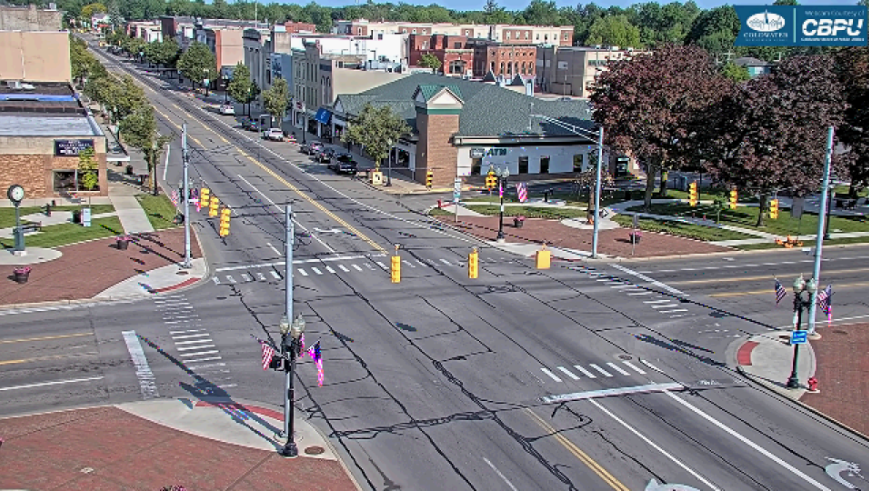

Apenas um exemplo simples foi mostrado acima, mas o processo experimental teve outras mais etapas, disponível em:
mapa_movimento_analise.ipynb (no drive)

https://drive.google.com/file/d/1H_oSWooSAaLQc3rF9okkP_obnUM3cKX7/view?usp=drive_link

### Ler todas as imagens e calcular realce

In [ ]:
## ETAPA 2

"""
Esse processo foi realizado em outro notebook, apesar de um processo simples, 
os resultados podem ser vistos no drive.

dataset_realce (drive)

https://drive.google.com/drive/folders/1gY2hLKCyydtXuIA7f1w40T3L2jXbhZfs?usp=drive_link
"""

## Modelagem

In [ ]:
"""
Esse processo foi realizado em outro notebook, apesar de um processo simples, 
os resultados podem ser vistos no drive.

fine_tuning.ipynb (no drive)

https://drive.google.com/file/d/1lPYQXymNWfZTLeiBNsxCQi3v18LGLJIB/view?usp=drive_link
"""

RESULTADOS apresentados no relatório

Vários vídeos de tratamentos parciais das imagens também estão disponíveis lá. Isso evita que os códigos tenham que ser rodados novamente, uma vez que o processamento de vídeos é lento.